## ***SIMULACIÓN***  
Métodos necesarios para la simulación del inventario

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

Inicialización de variables

In [2]:
x_1 = 70 #numero de unidades del producto 1
x_2 = 70 #numero de unidades del producto 2
T_simulacion = 5*24*30
#T_simulacion = 5*30*24 #tiempo transcurrido en la simulacion en horas
Tp = 7*24 #cada cuanto pide (cada semana)
lista = {'tc': 0,  # tiempo en el que ha llegado un cliente
         'tpc': 0, # tiempo en el que se ha comprado un pedido
         'tp': 0}  # tiempo en el que ha llegado un pedido
R = 0 #beneficio esperado
P1 = 1000 #numero de unidades max del producto 1
P2 = 1500 #numero de unidades max del producto 2
Nc = 0 #numero de clientes satisfechos
Nnc = 0 # numero de clientes no satisfechos
t0 = 0 # numero de tiempo que el intervalo esta a cero
C = 0 #coste total por pedidos
H = 0 #coste total por almacenamiento
lambda_poisson = 0.5
demanda = [1, 2, 3, 4] #posibles demandas del producto
probab_1 = [0.3, 0.4, 0.2, 0.1] #probabilidades de demanda del producto 1
probab_2 = [0.2, 0.2, 0.4, 0.2] #probabilidades de demanda del producto 2
r_1 = 2.5 #coste al publico del producto 1
r_2 = 3.5 #coste al publico del producto 2
h = 0.0002 #precio sumado por producto y unidad de tiempo
mu = 48 #tiempo de media que tarda un pedido
sigma = 3.5 #desviacion tipica de lo que tarda un pedido
K = 100 #coste fijo del proveedor
n_descuent_1 = 600 #unidades mayores a estas obtienen descuento en producto 1
p1_1 = 1 # precio si son menos de 600 uds del producto 1
p1_2 = 0.75 # precio si son mas de 600 uds del producto 1
n_descuent_2 = 800
p2_1 = 1.5
p2_2 = 1.25
L = 0 #lo que tarda en llegar el pedido desde que se compra
Lref = 48 #tiempo media de llegada del pedido
lim_penal = 3 #a partir de estas horas de retraso del pedido, penalizacion
penal = 0.0003 # la penalizacion en el precio si llega tarde/pronto 
t_real = 0
var_aux = 0 # instante en el que el almacen se vacia completamnete
ts = 0 #tiempo de simulacion

#Vectores para la representación gráfica de los niveles de inventario de los dos tipos de producto a lo largo del tiempo

tiempos_1 = [0]
niveles_1 = [70]
tiempos_2 = [0]
niveles_2 = [70]

# datos_grafica [producto 1 o 2] [tiempo (0) o nivel(1)] [i]  
datos_grafica = ["",
                 [[0],[70]], # tiempo y nivel producto 1
                 [[0],[70]]  # tiempo y nivel producto 2
                ]

Métodos para la simulación

In [3]:
def rutina_llegada_cliente(ts):
    global H, h, t_real, x_1, x_2, Nc, Nnc, var_aux, R, Y, y_1, y_2
    global r_1, r_2, var_aux, T_simulacion, tiempos_1, tiempos_2
    global niveles_1, niveles_2
  
    #Aumenta el coste de almacenamiento
    H += (ts-t_real)*h*(x_1+x_2)
    t_real = ts
  
    #Generamos demanda del cliente
    demanda_1 = np.random.choice(demanda, 1, p=probab_1)[0]
    demanda_2 = np.random.choice(demanda, 1, p=probab_2)[0]
  
    #Si hay suficiente almacenado, esta satisfecho
    if demanda_1<=x_1 and demanda_2<=x_2 :
        R += demanda_1*r_1 + demanda_2*r_2 #sube el beneficio
        x_1 -= demanda_1   #baja el inventario
        x_2 -= demanda_2
        Nc += 1 #cliente satisfecho
    #Si no hay suficiente almacenado de algun producto, no esta satisfecho
    else:
        Nnc += 1 #cliente no satisfecho
        if demanda_1 <= x_1:
            R += demanda_1*r_1 
            x_1 -= demanda_1
        elif demanda_2 <= x_2:
            R += demanda_2*r_2 
            x_2 -= demanda_2
    
    # Si se ha vaciado del todo (y antes no estaba vacio) guardamos el tiempo actual
    if x_2 == 0 and x_1 == 0 and var_aux == 0 :
        var_aux = t_real
    
    #Generamos el tiempo que tarda en llegar el siguiente cliente
    Y = stats.poisson.rvs(lambda_poisson, size=1)[0] 
  
    # si el cliente llega antes de acabar la simulacion, se simula
    if Y+t_real < T_simulacion:
        lista['tc'] = t_real+Y 

In [4]:
def rutina_llegada_pedido(ts):
    global H, K, h, t_real, C, t0, var_aux, x_1, x_2, y_1, y_2
    global p1_1, p1_2, p2_1, p2_1, penal, var_aux
    global tiempos_1, tiempos_2, niveles_1, niveles_2
  
    #Aumenta el coste de almacenamiento
    H += (ts-t_real)*h*(x_1+x_2)
    t_real = ts
  
    #Aumenta el nivel de inventario
    x_1 += y_1
    x_2 += y_2
  
    #Si son muchas unidades, descuento en el precio
    Ci_1 = K + y_1 * p1_1 if y_1<=n_descuent_1 else K + y_1 * p1_2
    Ci_2 = K + y_2 * p2_1 if y_2<=n_descuent_2 else K + y_2 * p2_2
  
    #Si llega pronto es mas caro, si llega tarde, es mas barato
    if L < Lref-lim_penal:
        C += (Ci_1 + Ci_2) * (1 + penal)
    elif L > Lref+lim_penal:
        C += (Ci_1 + Ci_2) * (1 - penal)
    else:
        C += Ci_1 + Ci_2
  
    #Ya no quedan productos por llegar
    y_1 = 0
    y_2 = 0
  
    # Si estaba vacio el invenario (se vacio en el instante var_aux),
    # aumenta el tiempo que ha estado vacio.
    if var_aux > 0:
        t0 += t_real - var_aux
        var_aux = 0

In [5]:
def rutina_compra_pedido(ts):
    global H, x_1, x_2, t_real, y_1, y_2, h, t_real
    global P1, P2, lista, T_simulacion

    # Aumenta el coste de almacenamiento
    H += (ts-t_real)*h*(x_1+x_2)
    t_real = ts
  
    #Cantidad a pedir es lo que falta para llenar el almacen
    y_1 = P1 - x_1
    y_2 = P2 - x_2

    #Generamos cuanto va a tardar en llegar el pedido
    L = np.random.normal(mu, sigma, 1)[0]

    # actualizamos el tiempo de llegada del pedido y el tiempo de siguiente compra
    if L+t_real < T_simulacion:
        lista['tp'] = t_real + L
    
    if t_real+Tp < T_simulacion:
        lista['tpc'] = t_real + Tp

Rutina para la simulación

In [6]:
def simul_main(periodicidad,nivel_1,nivel_2):
    global x_1, x_2, T_simulacion , Tp, lista, R, P1, P2, Nc, Nnc, t0, C, H
    global lambda_poisson, demanda, probab_1, probab_2, r_1, r_2, h, mu, sigma
    global K, n_descuent_1, p1_1, p1_2, p2_1, p2_2, n_descuent_2, L, Lref
    global lim_penal, penal, treal, var_aux, ts
  
    #Reseteamos las variables
    x_1 = 70 #numero de unidades del producto 1
    x_2 = 70 #numero de unidades del producto 2
    T_simulacion = 5*24*30 #tiempo transcurrido en la simulacion en horas
    Tp = periodicidad #cada cuanto pide (cada semana)
    lista = {'tc': 0,  # tiempo en el que ha llegado un cliente
            'tpc': 0, # tiempo en el que se ha comprado un pedido
            'tp': 0}  # tiempo en el que ha llegado un pedido
    R = 0 #beneficio esperado
    P1 = nivel_1 #numero de unidades max del producto 1
    P2 = nivel_2 #numero de unidades max del producto 2
    Nc = 0 #numero de clientes satisfechos
    Nnc = 0 # numero de clientes no satisfechos
    t0 = 0 # numero de tiempo que el intervalo esta a cero
    C = 0 #coste total por pedidos
    H = 0 #coste total por almacenamiento
    lambda_poisson = 0.5
    demanda = [1, 2, 3, 4] #posibles demandas del producto
    probab_1 = [0.3, 0.4, 0.2, 0.1] #probabilidades de demanda del producto 1
    probab_2 = [0.2, 0.2, 0.4, 0.2] #probabilidades de demanda del producto 2
    r_1 = 2.5 #coste al publico del producto 1
    r_2 = 3.5 #coste al publico del producto 2
    h = 0.0002 #precio sumado por producto y unidad de tiempo
    mu = 48 #tiempo de media que tarda un pedido
    sigma = 3.5 #desviacion tipica de lo que tarda un pedido
    K = 100 #coste fijo del proveedor
    n_descuent_1 = 600 #unidades mayores a estas obtienen descuento en producto 1
    p1_1 = 1 # precio si son menos de 600 uds del producto 1
    p1_2 = 0.75 # precio si son mas de 600 uds del producto 1
    n_descuent_2 = 800
    p2_1 = 1.5
    p2_2 = 1.25
    
    L = 0 #lo que tarda en llegar el pedido desde que se compra
    Lref = 48 #tiempo media de llegada del pedido
    lim_penal = 3 #a partir de estas horas de retraso del pedido, penalizacion
    penal = 0.0003 # la penalizacion en el precio si llega tarde/pronto 
    t_real = 0
    var_aux = 0 # instante en el que el almacen se vacia completamnete
    ts = 0 #tiempo de simulacion
  
    # Iniciamos siumlacion
    ts = 0
    lista['tc'] = 4000
    lista['tp'] = 4000
    lista['tpc'] = Tp
    
    #Generamos el tiempo que tarda en llegar el primer cliente
    Z = stats.poisson.rvs(lambda_poisson, size=1)[0]

    #Si el tiempo si pasa del limite T, la simulación se acaba
    if Z > T_simulacion: return -1
  
    #print('** Llega el primer cliente')
    rutina_llegada_cliente(Z)
  
    #Repetir si siguen llegando clientes o siguen llegando pedidos
    while (lista['tc']!=4000 or lista['tp']!=4000) and ts <= T_simulacion:
    
        #Si el siguiente evento es la llegada de un cliente
        if lista['tc'] <= lista['tpc'] and lista['tc'] <= lista['tp']:
            ts = lista['tc']
            lista['tc'] = 4000
            rutina_llegada_cliente(ts)

        #Si el siguiente evento es la compra de un pedido 
        elif(lista['tpc']<=lista['tc'] and lista['tpc']<=lista['tp']):
            ts = lista['tpc']
            lista['tpc'] = 4000
            rutina_compra_pedido(ts)

        #Si el siguiente evento es una llegada de pedido
        elif(lista['tp']<=lista['tc'] and lista['tp']<=lista['tpc']):
            ts = lista['tp']
            lista['tp'] = 4000
            rutina_llegada_pedido(ts)
      
    benef = R - C - H                #Beneficios
    cl_satisf = Nc / (Nc + Nnc) *100 #Porcentaje de clientes satisfechos
    t0_tot = t0 / T_simulacion       #Tiempo que ha estado el almacen vacio
  
    return benef

## ***RECOCIDO SIMULADO*** 

In [7]:
import random
import math
import matplotlib

In [8]:
def buscando_temperatura(T,initial_state):
    lista_temp = []
    lista_prob = []
 
    while T > 7000:
        neighbor = get_neighbor(initial_state)
        initial_state["benef"] = get_benef(initial_state)
        neighbor["benef"] = get_benef(neighbor)
        benef_diff = neighbor["benef"] - initial_state["benef"]
        prob = math.exp( - abs(benef_diff) / T)
        lista_temp.append(T)
        lista_prob.append(prob)
        T-=10
    grafica('Temperatura inicial','Probabilidad',lista_temp,lista_prob)

In [9]:
def grafica(titulox,tituloy,x,*args):
    for n in args:
        plt.plot(x,n)
    plt.xlabel(titulox)
    plt.ylabel(tituloy)
    plt.show()

def grafica3(titulox, tituloy, x, niv1, niv2, periodo):
    plt.plot(x,niv1,label='Nivel producto 1')
    plt.plot(x,niv2,label='Nivel producto 2')
    plt.xlabel(titulox)
    plt.ylabel('Nivel máximo de inventario')
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(x,periodo)
    plt.xlabel(titulox)
    plt.ylabel('Periodo de realización de pedido')
    plt.show()

In [23]:
def recocido_simulado(initial_state):
    # HIPERPARAMETERS
    alpha = 0.95 #Ritmo de decrecimiento de la temperatura
    initial_temp = 7500
    max_it_sin_cambio = 300
    max_L = 10
    
    it_sin_cambio = 0 # Numero de iteraciones sin cambio
    L = 0 #Num de iteraciones donde mantenemos la temperatura
    iteraciones = 1 #Contador de iteraciones
    
    #Variables graficas
    lista_benef = []
    lista_temp = []
    lista_prob = []
    lista_sol = []
    lista_niv_1 = []
    lista_niv_2 =[]
    lista_periodo = []

    # Primera iteracion
    current_temp = initial_temp
    current_state = initial_state
    current_state["benef"] = get_benef(current_state)
    best_state = current_state
    
    while it_sin_cambio < max_it_sin_cambio:
        # Comprobar si el vecino es mejor
        neighbor = get_neighbor(current_state)
        neighbor["benef"] = get_benef(neighbor)

        benef_diff = neighbor["benef"] - current_state["benef"]
        prob = math.exp(-abs(benef_diff) / current_temp)

        # Si es mejor, aceptamos vecino
        # Si es peor, aceptamos si p>u
        if benef_diff > 0 or random.uniform(0, 1) < prob:
            current_state = neighbor
                        
        print("It."+str(iteraciones)+
                 "\tTemp.: "+str(int(current_temp))+
                    "\tProb.: "+str(prob)+
                    "\tBeneficio: "+str(current_state["benef"])+
                    "\tParametros: "+str(current_state["periodicidad"])+", "+
                                                        str(current_state["nivel_1"])+", "+
                                                        str(current_state["nivel_2"]))

        
        
        lista_benef.append(best_state['benef'])
        lista_temp.append(current_temp)
        lista_prob.append(prob)
        lista_sol.append(current_state['benef'])
        lista_niv_1.append(current_state['nivel_1'])
        lista_niv_2.append(current_state['nivel_2'])
        lista_periodo.append(current_state['periodicidad'])

        # Bajamos temperatura
        if L==max_L:
            current_temp = current_temp * alpha
            L=0
        
        iteraciones += 1
        L += 1
        it_sin_cambio +=1 
        
        if best_state["benef"] < current_state["benef"]:
            best_state = current_state
            it_sin_cambio = 0
        
    grafica('Iteraciones','Mejor Solucion',range(1,iteraciones),lista_benef)
    grafica('Iteraciones','Temperatura',range(1,iteraciones),lista_temp)
    grafica('Iteraciones','Funcion fitness',range(1,iteraciones),lista_sol)
    grafica('Iteraciones','Factores de decision',range(1,iteraciones),lista_niv_1,lista_niv_2,lista_periodo)
    grafica3('Iteraciones','Factores de decision',range(1,iteraciones),lista_niv_1,lista_niv_2,lista_periodo)
    grafica('Iteraciones','Probabilidades',range(1,iteraciones),lista_prob)
    return best_state

In [13]:
def get_benef(state):
        return simul_main(state["periodicidad"], state["nivel_1"], state["nivel_2"])

In [14]:
def get_neighbor(state):
        """Returns neighbors of the argument state for your solution."""
        new_periodicidad = state["periodicidad"] + np.random.uniform(-1,1)
        new_nivel_1 = state["nivel_1"] + random.randint(-3,3)
        new_nivel_2 = state["nivel_2"] + random.randint(-3,3)

        neighbor = {'periodicidad':new_periodicidad ,    
                                            'nivel_1': new_nivel_1,
                                            'nivel_2': new_nivel_2 }

        return neighbor

It.1	Temp.: 7500	Prob.: 0.8071662480995906	Beneficio: 58094.337227196076	Parametros: 167.03648075842622, 1001, 1500
It.2	Temp.: 7500	Prob.: 0.8521930125606377	Beneficio: 56894.77044785759	Parametros: 167.05671943157694, 999, 1497
It.3	Temp.: 7500	Prob.: 0.873456048307088	Beneficio: 55880.03944207671	Parametros: 168.01931297199442, 998, 1498
It.4	Temp.: 7500	Prob.: 0.8201807346629366	Beneficio: 57366.76860371127	Parametros: 167.36980435201727, 996, 1501
It.5	Temp.: 7500	Prob.: 0.9006796412856953	Beneficio: 58151.310931170956	Parametros: 166.92624150014473, 998, 1499
It.6	Temp.: 7500	Prob.: 0.9587439589826358	Beneficio: 58151.310931170956	Parametros: 166.92624150014473, 998, 1499
It.7	Temp.: 7500	Prob.: 0.941490939724648	Beneficio: 57699.131774927395	Parametros: 166.4426502400959, 1001, 1499
It.8	Temp.: 7500	Prob.: 0.7843784775301431	Beneficio: 59520.60894868178	Parametros: 166.49663191866205, 998, 1500
It.9	Temp.: 7500	Prob.: 0.9990565314312813	Beneficio: 59513.529594316846	Parametros: 

It.72	Temp.: 5237	Prob.: 0.6832658444605287	Beneficio: 59373.124172813295	Parametros: 167.3254286585989, 1034, 1484
It.73	Temp.: 5237	Prob.: 0.8770944274775001	Beneficio: 58686.27127067028	Parametros: 167.2708305665486, 1037, 1481
It.74	Temp.: 5237	Prob.: 0.738585378499157	Beneficio: 57099.20248867404	Parametros: 167.71822237849824, 1036, 1484
It.75	Temp.: 5237	Prob.: 0.899294874453291	Beneficio: 57655.13639136699	Parametros: 167.07143594590212, 1034, 1487
It.76	Temp.: 5237	Prob.: 0.8444325943042246	Beneficio: 58540.75219412816	Parametros: 166.98259080378807, 1035, 1486
It.77	Temp.: 5237	Prob.: 0.5954069472921432	Beneficio: 58540.75219412816	Parametros: 166.98259080378807, 1035, 1486
It.78	Temp.: 5237	Prob.: 0.6885323889148348	Beneficio: 56586.1431882788	Parametros: 166.00483520556136, 1038, 1483
It.79	Temp.: 5237	Prob.: 0.712986964550992	Beneficio: 58357.95833247197	Parametros: 166.50173882633126, 1039, 1480
It.80	Temp.: 5237	Prob.: 0.5223040858790838	Beneficio: 54956.154911489044	Par

It.143	Temp.: 3657	Prob.: 0.7692651324559	Beneficio: 58075.13352958023	Parametros: 170.27910426075425, 1060, 1471
It.144	Temp.: 3657	Prob.: 0.684407683504269	Beneficio: 59462.086694563375	Parametros: 169.3319925345711, 1059, 1469
It.145	Temp.: 3657	Prob.: 0.6637984983813066	Beneficio: 57963.30308012654	Parametros: 169.46768417519309, 1056, 1469
It.146	Temp.: 3657	Prob.: 0.929667146204093	Beneficio: 57696.56194417331	Parametros: 170.078963072185, 1056, 1466
It.147	Temp.: 3657	Prob.: 0.9998399758223984	Beneficio: 57697.147289415276	Parametros: 170.74344673030288, 1053, 1469
It.148	Temp.: 3657	Prob.: 0.9616473819700397	Beneficio: 57840.18519778964	Parametros: 170.27388432241193, 1052, 1472
It.149	Temp.: 3657	Prob.: 0.727790639656771	Beneficio: 59002.34584167483	Parametros: 170.4330063318134, 1053, 1470
It.150	Temp.: 3657	Prob.: 0.6336563661042193	Beneficio: 59002.34584167483	Parametros: 170.4330063318134, 1053, 1470
It.151	Temp.: 3657	Prob.: 0.842749647181781	Beneficio: 59002.34584167483	

It.214	Temp.: 2554	Prob.: 0.5805385329246537	Beneficio: 58127.52664737665	Parametros: 168.6851853338861, 1066, 1468
It.215	Temp.: 2554	Prob.: 0.7882836591432947	Beneficio: 57519.886512191646	Parametros: 168.63843917241488, 1069, 1466
It.216	Temp.: 2554	Prob.: 0.3951860047587929	Beneficio: 59891.2138640006	Parametros: 168.5644500916574, 1068, 1463
It.217	Temp.: 2554	Prob.: 0.9481591628666863	Beneficio: 59755.24574791504	Parametros: 169.5305001457143, 1069, 1465
It.218	Temp.: 2554	Prob.: 0.3962172301163599	Beneficio: 59755.24574791504	Parametros: 169.5305001457143, 1069, 1465
It.219	Temp.: 2554	Prob.: 0.341350404560017	Beneficio: 57009.86162334668	Parametros: 168.91489878614394, 1068, 1462
It.220	Temp.: 2554	Prob.: 0.8014620577181242	Beneficio: 56444.56938956298	Parametros: 168.21665286583752, 1066, 1463
It.221	Temp.: 2554	Prob.: 0.5758630700091054	Beneficio: 57854.201738737574	Parametros: 167.74999343815335, 1065, 1463
It.222	Temp.: 2426	Prob.: 0.43300902741088	Beneficio: 57854.20173873

It.285	Temp.: 1783	Prob.: 0.2392846274592596	Beneficio: 57011.58301947975	Parametros: 171.53676529900352, 1044, 1447
It.286	Temp.: 1783	Prob.: 0.8079057355706515	Beneficio: 57392.06422205333	Parametros: 171.85092526800506, 1044, 1446
It.287	Temp.: 1783	Prob.: 0.5427345473161355	Beneficio: 58482.14661950061	Parametros: 171.97532310373595, 1047, 1443
It.288	Temp.: 1783	Prob.: 0.8285885083064555	Beneficio: 58482.14661950061	Parametros: 171.97532310373595, 1047, 1443
It.289	Temp.: 1783	Prob.: 0.28291681493685783	Beneficio: 60734.252527345634	Parametros: 172.8453124767429, 1047, 1445
It.290	Temp.: 1783	Prob.: 0.10263696791959134	Beneficio: 60734.252527345634	Parametros: 172.8453124767429, 1047, 1445
It.291	Temp.: 1783	Prob.: 0.5312703124431452	Beneficio: 60734.252527345634	Parametros: 172.8453124767429, 1047, 1445
It.292	Temp.: 1694	Prob.: 0.20579699528201922	Beneficio: 60734.252527345634	Parametros: 172.8453124767429, 1047, 1445
It.293	Temp.: 1694	Prob.: 0.1238114817441848	Beneficio: 60734

It.355	Temp.: 1245	Prob.: 0.027098469880416805	Beneficio: 61709.507180564935	Parametros: 171.4259113402976, 1064, 1486
It.356	Temp.: 1245	Prob.: 0.028796852372756674	Beneficio: 61709.507180564935	Parametros: 171.4259113402976, 1064, 1486
It.357	Temp.: 1245	Prob.: 0.722419311358577	Beneficio: 61304.49265503186	Parametros: 171.32258584393827, 1064, 1487
It.358	Temp.: 1245	Prob.: 0.2617045854233608	Beneficio: 61304.49265503186	Parametros: 171.32258584393827, 1064, 1487
It.359	Temp.: 1245	Prob.: 0.06395103014874214	Beneficio: 61304.49265503186	Parametros: 171.32258584393827, 1064, 1487
It.360	Temp.: 1245	Prob.: 0.1302364239055264	Beneficio: 58765.40510386437	Parametros: 171.24811821145454, 1064, 1487
It.361	Temp.: 1245	Prob.: 0.5089509417516779	Beneficio: 57924.10517735687	Parametros: 171.73806020355295, 1066, 1489
It.362	Temp.: 1183	Prob.: 0.8024102355214341	Beneficio: 58184.60097198298	Parametros: 172.33514371323508, 1066, 1490
It.363	Temp.: 1183	Prob.: 0.7674734227205726	Beneficio: 5787

It.426	Temp.: 869	Prob.: 0.04299809631488495	Beneficio: 61094.461127939314	Parametros: 170.89901937767215, 1066, 1480
It.427	Temp.: 869	Prob.: 0.009742376252398814	Beneficio: 61094.461127939314	Parametros: 170.89901937767215, 1066, 1480
It.428	Temp.: 869	Prob.: 0.15848047478973293	Beneficio: 61094.461127939314	Parametros: 170.89901937767215, 1066, 1480
It.429	Temp.: 869	Prob.: 0.12296299322014768	Beneficio: 61094.461127939314	Parametros: 170.89901937767215, 1066, 1480
It.430	Temp.: 869	Prob.: 0.01087672786667801	Beneficio: 61094.461127939314	Parametros: 170.89901937767215, 1066, 1480
It.431	Temp.: 869	Prob.: 0.036799678951481236	Beneficio: 61094.461127939314	Parametros: 170.89901937767215, 1066, 1480
It.432	Temp.: 826	Prob.: 0.030142875240120517	Beneficio: 61094.461127939314	Parametros: 170.89901937767215, 1066, 1480
It.433	Temp.: 826	Prob.: 0.042314288904868054	Beneficio: 61094.461127939314	Parametros: 170.89901937767215, 1066, 1480
It.434	Temp.: 826	Prob.: 0.02451518126472149	Benefic

It.497	Temp.: 607	Prob.: 0.035469763940943796	Beneficio: 60941.19393247988	Parametros: 169.33974936948752, 1071, 1476
It.498	Temp.: 607	Prob.: 4.313182999571242e-05	Beneficio: 60941.19393247988	Parametros: 169.33974936948752, 1071, 1476
It.499	Temp.: 607	Prob.: 9.435267608532432e-05	Beneficio: 60941.19393247988	Parametros: 169.33974936948752, 1071, 1476
It.500	Temp.: 607	Prob.: 0.16441269527833302	Beneficio: 60941.19393247988	Parametros: 169.33974936948752, 1071, 1476
It.501	Temp.: 607	Prob.: 0.01894715858898704	Beneficio: 60941.19393247988	Parametros: 169.33974936948752, 1071, 1476
It.502	Temp.: 577	Prob.: 0.06112784480913713	Beneficio: 60941.19393247988	Parametros: 169.33974936948752, 1071, 1476
It.503	Temp.: 577	Prob.: 0.0012349303956110272	Beneficio: 60941.19393247988	Parametros: 169.33974936948752, 1071, 1476
It.504	Temp.: 577	Prob.: 0.006048329735492016	Beneficio: 60941.19393247988	Parametros: 169.33974936948752, 1071, 1476
It.505	Temp.: 577	Prob.: 0.012635805019296186	Beneficio:

It.567	Temp.: 424	Prob.: 6.462650791183274e-05	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.568	Temp.: 424	Prob.: 0.0004149263571330205	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.569	Temp.: 424	Prob.: 0.0005863547120849788	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.570	Temp.: 424	Prob.: 3.761023321934301e-07	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.571	Temp.: 424	Prob.: 3.758086760690819e-06	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.572	Temp.: 403	Prob.: 4.5329744389489524e-07	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.573	Temp.: 403	Prob.: 0.0027013262502885798	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.574	Temp.: 403	Prob.: 0.0021009189764123427	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.575	Temp.: 403	Prob.: 5.0413947958322435e-05	Beneficio: 6200

It.637	Temp.: 296	Prob.: 1.0640846788981766e-12	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.638	Temp.: 296	Prob.: 3.30914717907992e-14	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.639	Temp.: 296	Prob.: 1.1370449758180077e-06	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.640	Temp.: 296	Prob.: 1.1258186604145856e-07	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.641	Temp.: 296	Prob.: 4.880789355170714e-06	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.642	Temp.: 281	Prob.: 2.4555882372825178e-05	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.643	Temp.: 281	Prob.: 2.012299556261888e-07	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.644	Temp.: 281	Prob.: 5.101247525296352e-06	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.645	Temp.: 281	Prob.: 2.2755974437534644e-09	Beneficio: 62

It.707	Temp.: 206	Prob.: 1.6573951196917912e-11	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.708	Temp.: 206	Prob.: 8.940041647924182e-12	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.709	Temp.: 206	Prob.: 1.4236602351732182e-15	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.710	Temp.: 206	Prob.: 7.134088837554731e-12	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.711	Temp.: 206	Prob.: 6.809788472868665e-11	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.712	Temp.: 196	Prob.: 2.175542864971934e-13	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.713	Temp.: 196	Prob.: 2.688070805448216e-18	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.714	Temp.: 196	Prob.: 1.6025541093570223e-09	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.715	Temp.: 196	Prob.: 5.6212696671680614e-11	Beneficio: 62

It.777	Temp.: 144	Prob.: 6.844288544784408e-17	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.778	Temp.: 144	Prob.: 1.1074171900110636e-17	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.779	Temp.: 144	Prob.: 4.2509501740691924e-14	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.780	Temp.: 144	Prob.: 7.38999067559011e-11	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.781	Temp.: 144	Prob.: 1.2952138260190173e-11	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.782	Temp.: 137	Prob.: 4.1011396617734346e-19	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.783	Temp.: 137	Prob.: 3.8467426318984333e-19	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.784	Temp.: 137	Prob.: 2.0768717515135845e-10	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.785	Temp.: 137	Prob.: 4.9488079197394026e-15	Beneficio: 

It.847	Temp.: 100	Prob.: 1.94777872723494e-17	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.848	Temp.: 100	Prob.: 1.2431718312988785e-15	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.849	Temp.: 100	Prob.: 3.0428032407979374e-34	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.850	Temp.: 100	Prob.: 2.3865543938399506e-28	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.851	Temp.: 100	Prob.: 7.070616895266671e-28	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.852	Temp.: 95	Prob.: 5.066830444368044e-18	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.853	Temp.: 95	Prob.: 2.5453186535143635e-22	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.854	Temp.: 95	Prob.: 4.615094102806409e-22	Beneficio: 62006.91302597619	Parametros: 165.629957928881, 1070, 1470
It.855	Temp.: 95	Prob.: 2.6787558383085474e-10	Beneficio: 62006.

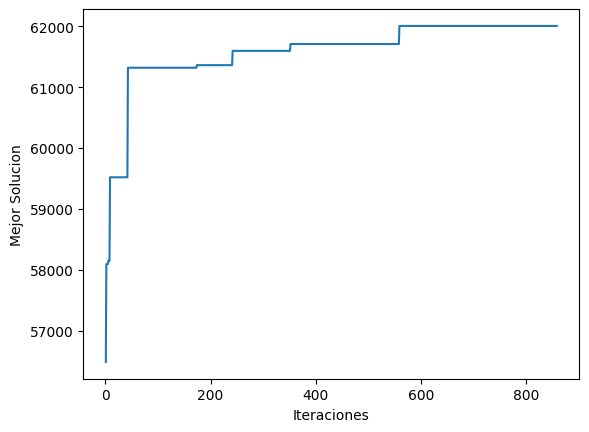

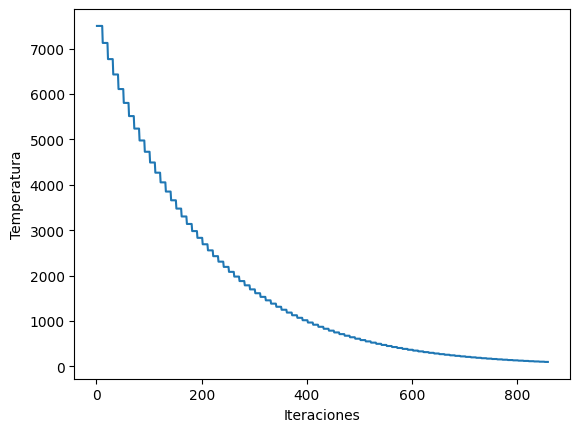

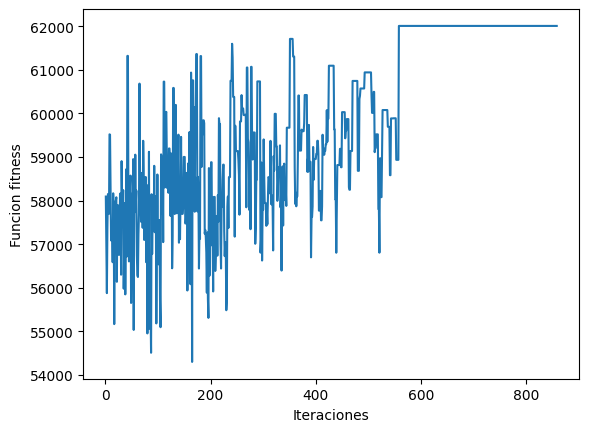

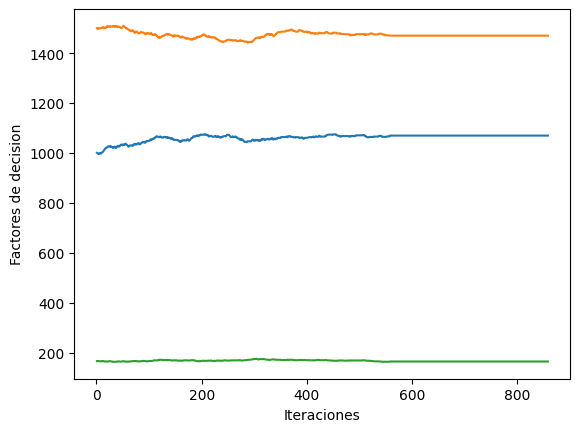

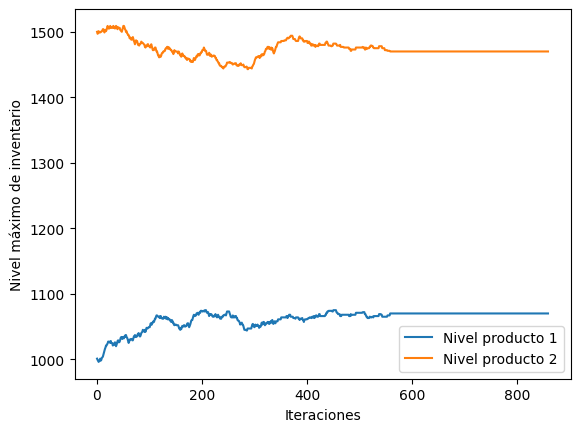

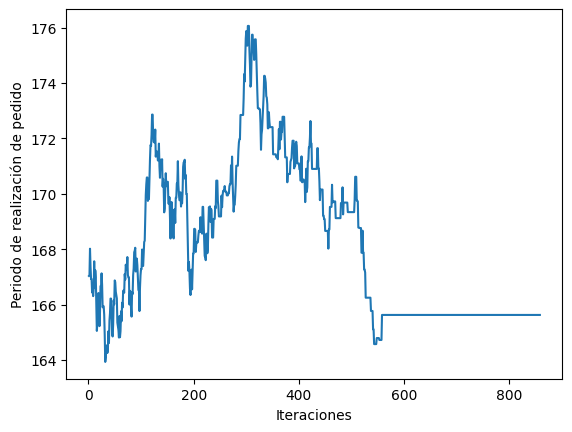

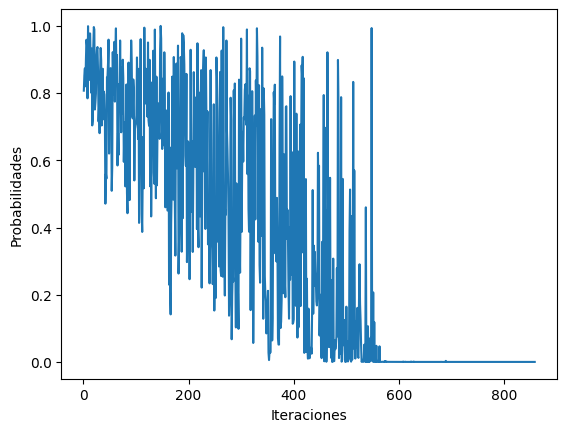

{'periodicidad': 165.629957928881,
 'nivel_1': 1070,
 'nivel_2': 1470,
 'benef': 62006.91302597619}

In [26]:
initial_state = {'periodicidad': 168, #168 h = 5 días   
                      'nivel_1': 1000,
                      'nivel_2': 1500 }

recocido_simulado(initial_state)

In [ ]:
initial_state = {'periodicidad':168 ,  
                      'nivel_1': 1500,
                      'nivel_2': 1000 }
#buscando_temperatura(8000, initial_state)

In [15]:
iteraciones=3
lista_niv_1 = [1000,1010,1020]
lista_niv_2 = [1500,1510,1520]
lista_periodo = [120, 125, 112]

#grafica3('Iteraciones','Factores de decision',range(iteraciones),lista_niv_1,lista_niv_2,lista_periodo)